In [12]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import poisson 

from tqdm import trange

In [13]:
# Setting up the environment variables

# maximum # of cars in each location
MAX_CARS = 20

# maximum # of cars to move during night
MAX_MOVE_OF_CARS = 5

# expectation for rental requests in first location
E_RENTAL_REQUEST_FIRST_LOC = 3

# expectation for rental requests in second location
E_RENTAL_REQUEST_SECOND_LOC = 4

# expectation for # of cars returned in first location
E_RETURNS_FIRST_LOC = 3

# expectation for # of cars returned in second location
E_RETURNS_SECOND_LOC = 2

# discount raio is set at 0.9
DISCOUNT = 0.9

# credit earned by a car
RENTAL_CREDIT = 10

# cost of moving a car
MOVE_CAR_COST = 2

# action space: positive number means moving cars from first location to second location and vice versa
action_space = np.arange(-MAX_MOVE_OF_CARS, MAX_MOVE_OF_CARS + 1)

# An up bound for poisson distribution
# If n is greater than this value, then the probability of getting n is truncated to 0 (avoid unnecessary calculation)
POISSON_UPPER_BOUND = 11

# Probability for poisson distribution
# Pre-calculate all the pmf for poisson distribution to avoid repetitive computation.
P = dict()

for n in range(POISSON_UPPER_BOUND):
    for lam in [E_RENTAL_REQUEST_FIRST_LOC, E_RENTAL_REQUEST_SECOND_LOC, E_RETURNS_FIRST_LOC, E_RETURNS_SECOND_LOC]:
        P[(n, lam)] = poisson.pmf(n, lam)

In [14]:
def expected_return(state, action, state_value, constant_returned_cars):
    """
    @state: [# of cars in first location, # of cars in second location]
    @action: positive if moving cars from first location to second location,
            negative if moving cars from second location to first location
    @stateValue: state value matrix
    @constant_returned_cars:  if set True, model is simplified such that
    the # of cars returned in daytime becomes constant
    rather than a random value from poisson distribution, which will reduce calculation time
    and leave the optimal policy/value state matrix almost the same
    """
    # initailize total return
    returns = 0.0

    # cost for moving cars
    returns -= MOVE_CAR_COST * abs(action)

    # moving cars
    NUM_OF_CARS_FIRST_LOC = min(state[0] - action, MAX_CARS)
    NUM_OF_CARS_SECOND_LOC = min(state[1] + action, MAX_CARS)

    # go through all possible rental requests
    for rental_request_first_loc in range(POISSON_UPPER_BOUND):
        for rental_request_second_loc in range(POISSON_UPPER_BOUND):
            # probability for current combination of rental requests
            prob_request = P[(rental_request_first_loc, E_RENTAL_REQUEST_FIRST_LOC)] * \
                P[(rental_request_second_loc, E_RENTAL_REQUEST_SECOND_LOC)]

            num_of_cars_first_loc = NUM_OF_CARS_FIRST_LOC
            num_of_cars_second_loc = NUM_OF_CARS_SECOND_LOC

            # valid rental requests should be less than actual # of cars
            valid_rental_first_loc = min(num_of_cars_first_loc, rental_request_first_loc)
            valid_rental_second_loc = min(num_of_cars_second_loc, rental_request_second_loc)

            # get credits for renting
            reward = (valid_rental_first_loc + valid_rental_second_loc) * RENTAL_CREDIT
            num_of_cars_first_loc -= valid_rental_first_loc
            num_of_cars_second_loc -= valid_rental_second_loc

            if constant_returned_cars:
                # get returned cars, those cars can be used for renting tomorrow
                returned_cars_first_loc = E_RETURNS_FIRST_LOC
                returned_cars_second_loc = E_RETURNS_SECOND_LOC
                num_of_cars_first_loc = min(num_of_cars_first_loc + returned_cars_first_loc, MAX_CARS)
                num_of_cars_second_loc = min(num_of_cars_second_loc + returned_cars_second_loc, MAX_CARS)
                returns += prob_request * (reward + DISCOUNT * state_value[num_of_cars_first_loc, num_of_cars_second_loc])
            else:
                for returned_cars_first_loc in range(POISSON_UPPER_BOUND):
                    for returned_cars_second_loc in range(POISSON_UPPER_BOUND):
                        prob_return = P[(returned_cars_first_loc, E_RETURNS_FIRST_LOC)] * \
                            P[(returned_cars_second_loc, E_RETURNS_SECOND_LOC)]
                        num_of_cars_first_loc_ = min(num_of_cars_first_loc + returned_cars_first_loc, MAX_CARS)
                        num_of_cars_second_loc_ = min(num_of_cars_second_loc + returned_cars_second_loc, MAX_CARS)
                        returns += (prob_return * prob_request) * (reward + DISCOUNT *
                                            state_value[num_of_cars_first_loc_, num_of_cars_second_loc_])
    return returns

# TODO: break this function down to policy eval and improvement
def figure_4_2(constant_returned_cars=True):
    value = np.zeros((MAX_CARS + 1, MAX_CARS + 1))
    policy = np.zeros(value.shape, dtype=int)

    iterations = 0
    _, axes = plt.subplots(2, 3, figsize=(40, 20))
    plt.subplots_adjust(wspace=0.1, hspace=0.2)
    axes = axes.flatten()
    while True:
        fig = sns.heatmap(np.flipud(policy), cmap="YlGnBu", ax=axes[iterations])
        fig.set_ylabel('# cars at first location', fontsize=30)
        fig.set_yticks(list(reversed(range(MAX_CARS + 1))))
        fig.set_xlabel('# cars at second location', fontsize=30)
        fig.set_title('policy {}'.format(iterations), fontsize=30)

        # policy evaluation (in-place)
        while True:
            old_value = value.copy()
            for i in range(MAX_CARS + 1):
                for j in range(MAX_CARS + 1):
                    new_state_value = expected_return([i, j], policy[i, j], value, constant_returned_cars)
                    value[i, j] = new_state_value
            max_value_change = abs(old_value - value).max()
            print('max value change {}'.format(max_value_change))
            if max_value_change < 1e-4:
                break

        # policy improvement
        policy_stable = True
        for i in range(MAX_CARS + 1):
            for j in range(MAX_CARS + 1):
                old_action = policy[i, j]
                action_returns = []
                for action in action_space:
                    if (0 <= action <= i) or (-j <= action <= 0):
                        action_returns.append(expected_return([i, j], action, value, constant_returned_cars))
                    else:
                        action_returns.append(-np.inf)
                new_action = action_space[np.argmax(action_returns)]
                policy[i, j] = new_action
                if policy_stable and old_action != new_action:
                    policy_stable = False
        print('policy stable {}'.format(policy_stable))

        if policy_stable:
            fig = sns.heatmap(np.flipud(value), cmap="YlGnBu", ax=axes[-1])
            fig.set_ylabel('# cars at first location', fontsize=30)
            fig.set_yticks(list(reversed(range(MAX_CARS + 1))))
            fig.set_xlabel('# cars at second location', fontsize=30)
            fig.set_title('optimal value', fontsize=30)
            break

        iterations += 1

    plt.show()

max value change 196.62783361783852
max value change 134.98823859766583
max value change 91.41415360228919
max value change 67.17097732555729
max value change 51.29055484635097
max value change 38.49091000659837
max value change 29.406139835126424
max value change 25.7210573245398
max value change 22.381602293031023
max value change 19.40385808254939
max value change 16.77577350573091
max value change 14.47251552455765
max value change 12.464101852186843
max value change 10.719367983418692
max value change 9.20806226246873
max value change 7.9019189666795455
max value change 6.775146571130392
max value change 5.8045764710083745
max value change 4.969618520007145
max value change 4.252112693842776
max value change 3.6361309524054946
max value change 3.107761240497666
max value change 2.654891834022692
max value change 2.26700589940549
max value change 1.9349911763441128
max value change 1.650966802154585
max value change 1.4081276418079938
max value change 1.2006055672075036
max value c

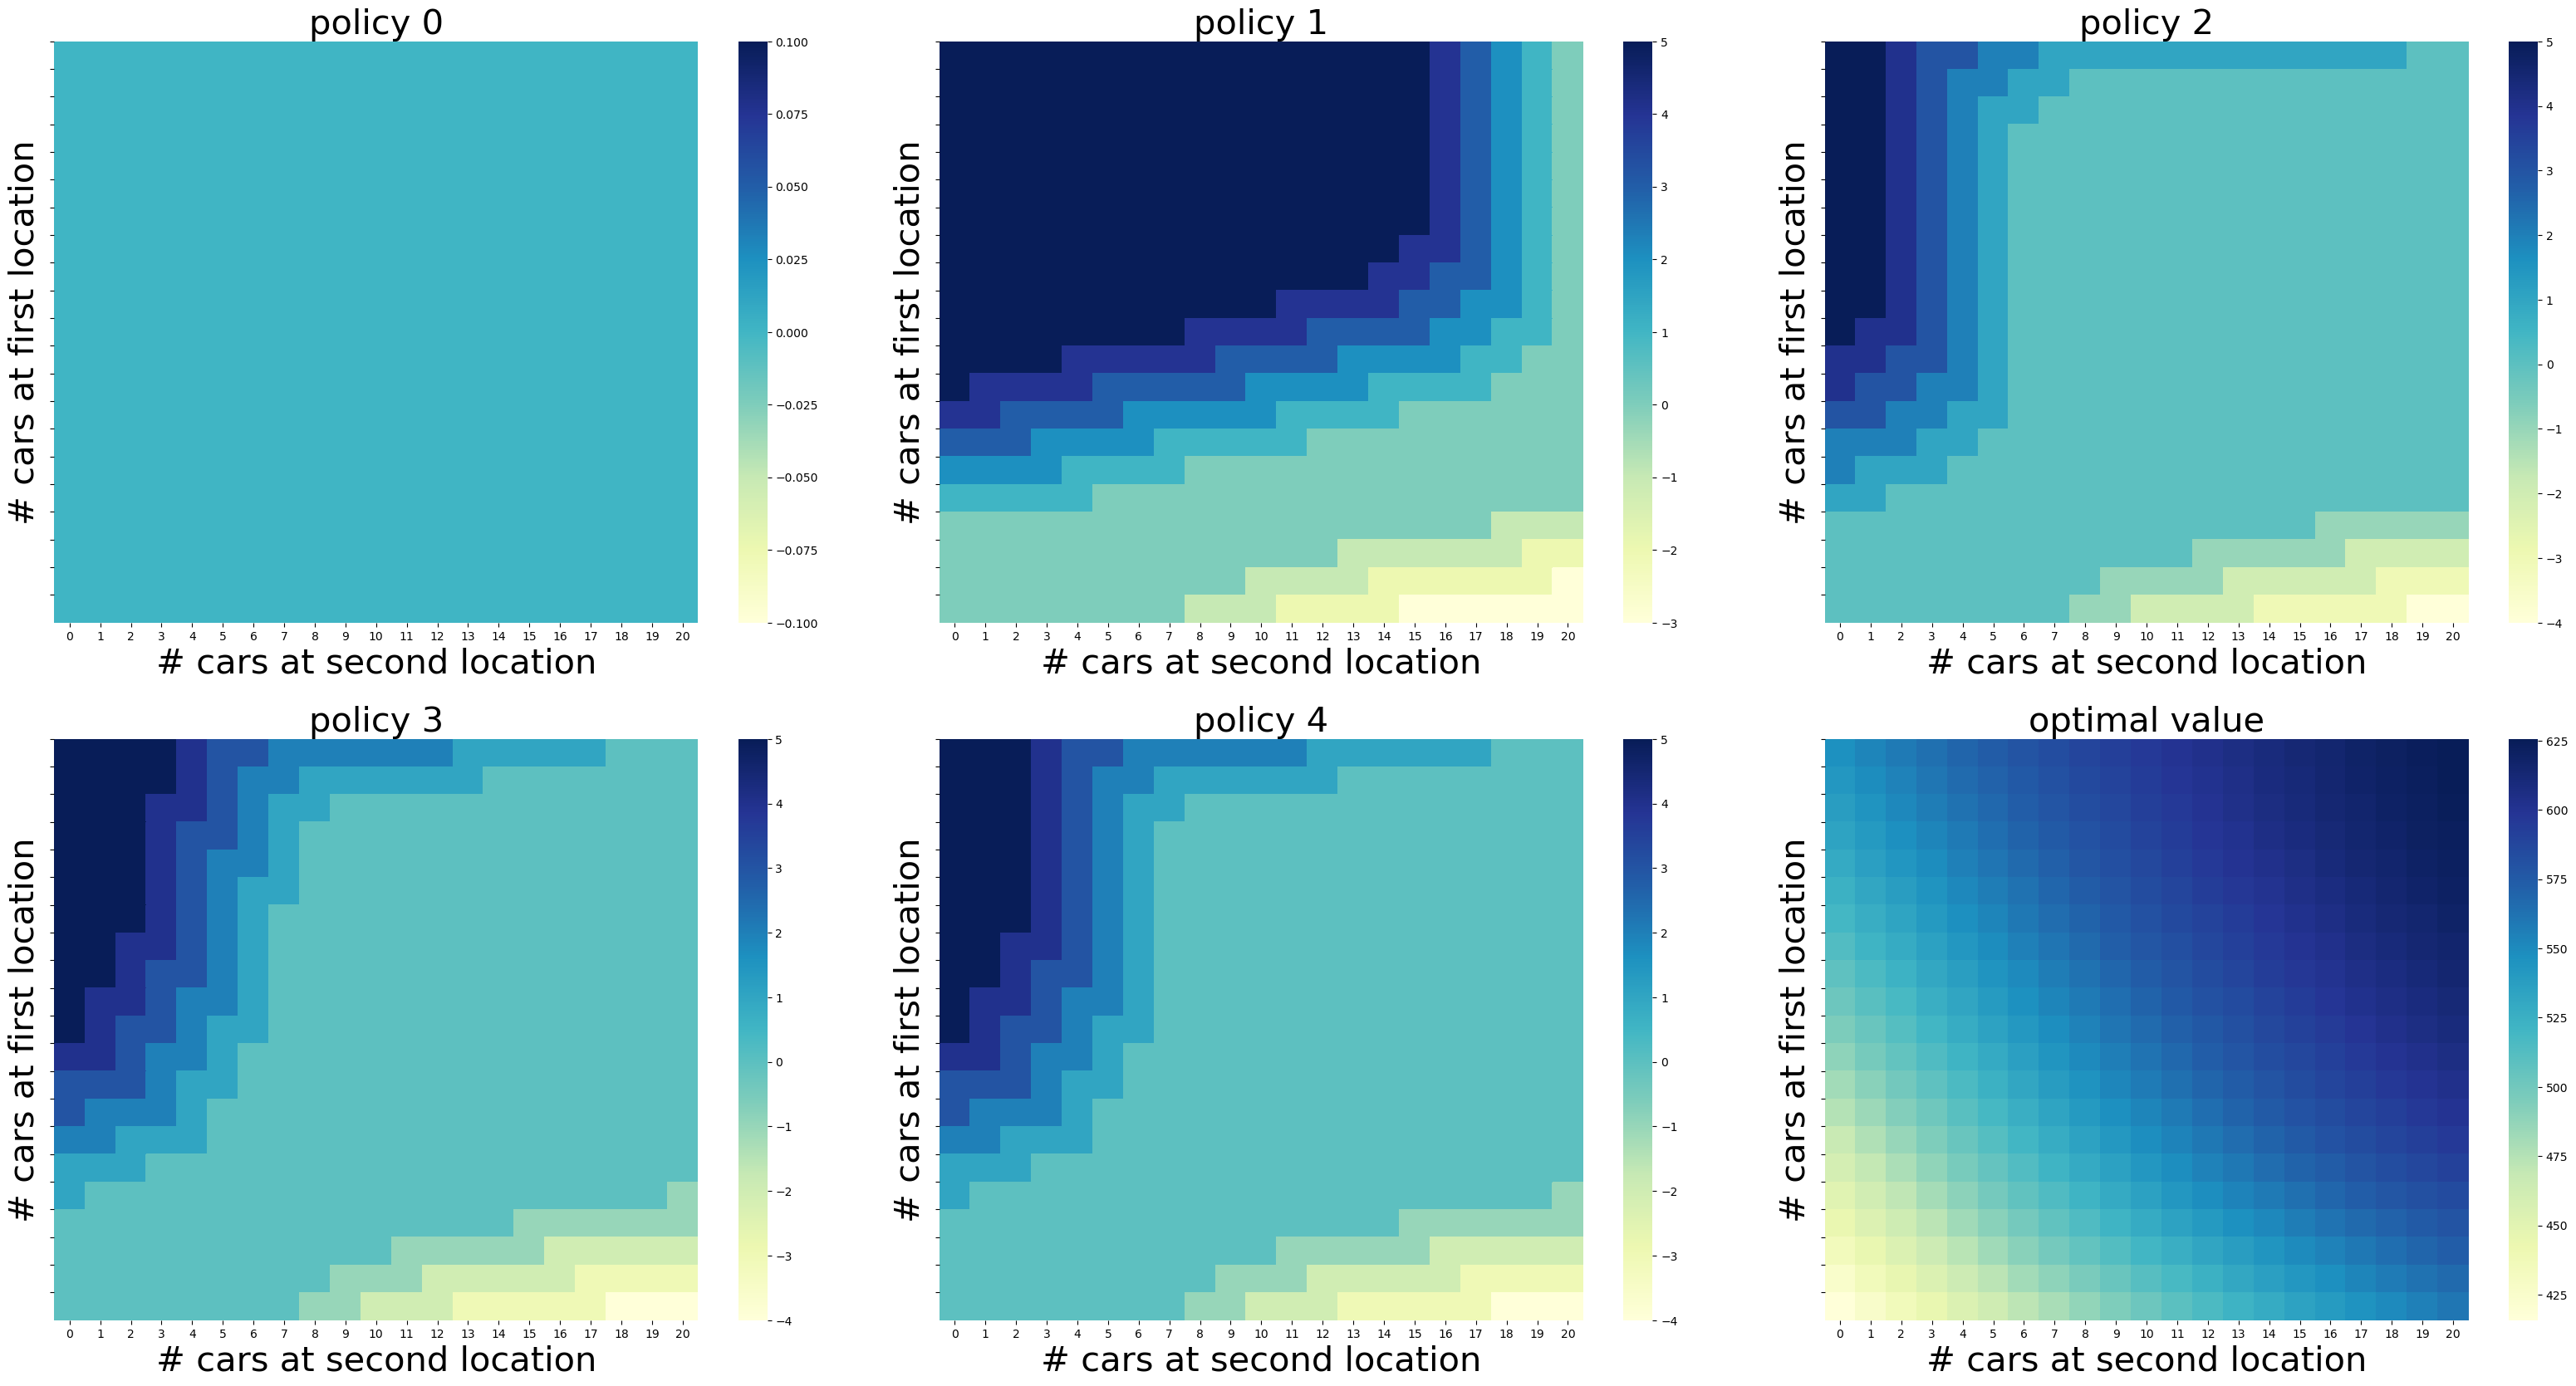

In [15]:
figure_4_2()